In [461]:
import sys
sys.path.append("../../marineHeatWaves/")
sys.path.append("physiology/")

import marineHeatWaves as mh

from tpc import tpc

import xarray as xr
import numpy as np
import zarr

import pandas as pd

import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial

from dask.distributed import Client

import cloudpickle

import gcsfs
import s3fs 
import boto3

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

In [2]:
client = Client()

In [3]:
client

Client Scheduler: tcp://127.0.0.1:42957 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 32 Memory: 132.82 GB


# Phytoplankton Isolates + MHWs. 

Tony Cannistra, Apr 2020

Taking a step back from latitudinally extrapolating thermal reaction norms, we instead move to looking at SST dynamics local to individual phytoplankton isolates to remove some potentially negative effects of the extrapolation . 

In [222]:
plankton = pd.read_csv("../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')
plankton = plankton[
    (plankton.habitat == 'marine') &
    (plankton.curvequal == 'good')
].dropna(subset=['isolation.latitude', 'isolation.longitude'], axis=0)
len(plankton)

89

In [224]:
plankton.head()

,isolate.code,source,isolation.latitude,isolation.longitude,habitat,name,speciesname,former.name.1,former.name.2,strain,...,minqual,maxqual,curvequal,abs.curveskew,rel.curveskew,used.for.optimum.analysis,used.for.tmax.analysis,used.for.tmin.analysis,used.for.niche.width.analysis,used.for.max.growth.rate.analysis
0,1,"Terra Nova Bay, Ross Sea, Antarctica",-74.83,164.50,marine,Koliella antarctica strain SAG 2030,Koliella antarctica,NaN,NaN,SAG 2030,...,good,good,good,-40.320257,-0.007766,1.0,1.0,1.0,1.0,1.0
2,3,"Windmill Islands, Antarctica",-66.28,110.48,marine,Klebsormidium strain UMACC 227,Klebsormidium,NaN,NaN,UMACC 227,...,good,good,good,277.833630,0.010216,0.0,0.0,0.0,0.0,0.0
3,5,"Arthur Harbor, Palmer Station, Antarctica",-64.78,-64.06,marine,Phaeocystis antarctica strain CCMP 1871,Phaeocystis antarctica,NaN,NaN,CCMP 1871,...,good,good,good,-5.192227,-0.005703,1.0,1.0,1.0,1.0,1.0
8,11,"Southern Ocean, Indian sector",-58.00,62.00,marine,Pseudo-nitzschia turgiduloides,Pseudo-nitzschia turgiduloides,Nitzschia turgiduloides,NaN,NaN,...,good,good,good,-4.634105,-0.004083,1.0,1.0,1.0,1.0,1.0
11,14,"Big Glory Bay, New Zealand",-46.98,168.12,marine,Emiliania huxleyi,Emiliania huxleyi,Coccolithus huxleyi,NaN,NaN,...,good,good,good,-111.068341,-0.013906,1.0,1.0,1.0,1.0,1.0


## Set up MHW detection

In [225]:

SAVED_PARAMS = [
    'intensity_max',
    'intensity_cumulative',
    'intensity_var',
    'intensity_mean',
    'rate_onset',
    'rate_decline',
    'index_start', 
    'index_end',
    'index_peak',
    'duration'
]
dim_idx_mapping = {
        **{
            i : SAVED_PARAMS[i]
            for i in range(len(SAVED_PARAMS))
        }, 
        **{
            len(SAVED_PARAMS): 'mhw',
            len(SAVED_PARAMS) + 1 : 'clim_thresh',
            len(SAVED_PARAMS) + 2 : 'clim_seas'
        }
}
def mhw_1d(temps, time):
    SAVED_PARAMS_loc = SAVED_PARAMS.copy()
    if(np.isnan(temps).any()): return np.zeros((len(SAVED_PARAMS_loc) + 3, time.shape[0]))

    ordinals =  np.array([pd.Timestamp(t).toordinal() for t in time])
    dets = mh.detect(ordinals, temps.copy())
    events = dets[0]['n_events']
    del dets[0]['n_events']
    
    arrays = [
        np.zeros_like(time, dtype='float64')
        for _ in range(len(SAVED_PARAMS_loc)) 
    ]
    arrays.append(np.zeros_like(time, dtype='int'))
    
    for event_i in range(events):
        start_date = dets[0]['index_start'][event_i]
        end_date = dets[0]['index_end'][event_i]
        
        # set binary param
        arrays[-1][start_date:end_date] = event_i
        # set all params
        for _i, param in enumerate(SAVED_PARAMS_loc):
#             print(f'saving param {param}')
            param_data = dets[0][param][event_i]
            arrays[_i][start_date:end_date] = param_data
                
        
    clim_thresh = dets[1]['thresh'] 
    clim_seas = dets[1]['seas']
        
    return np.array(
        arrays + [clim_thresh, clim_seas]
    )

def get_nearest_mhw_detections(sst, lat, lon):
    these_sst = sst.sel(lat=lat, lon=lon, method='nearest', tolerance=0.25)
    dets = xr.apply_ufunc(
        mhw_1d, 
        these_sst.sst.chunk({'time': -1}), 
        these_sst.time, 
        input_core_dims = [['time'], ['time']],
        output_core_dims=[["param","time"]],
        output_dtypes=['float64'],
        dask='parallelized', 
        output_sizes={"param": len(SAVED_PARAMS) + 3}, # + 3 for binary MHW detection parameter and climatology
        vectorize=True
    )
    return(dets.to_dataset(dim='param').rename_vars(dim_idx_mapping))

Load MHWs

In [226]:
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

Test on one example:

In [38]:
example_plank = plankton.sample(1)

In [66]:
dets = get_nearest_mhw_detections(oisst, example_plank['isolation.latitude'], example_plank['isolation.longitude'])

In [67]:
dets = dets.compute().to_dataset(dim='param').rename_vars(dim_idx_mapping)

Run all examples:

In [10]:
loc_dets = [get_nearest_mhw_detections(oisst, x['isolation.latitude'], x['isolation.longitude'])
               for _, x in plankton.iterrows()
           ]

In [11]:
loc_dets_values = client.compute(loc_dets, sync=True, optimize_graph=True)

## Compute TPCs for each isolate

In [229]:
tpcs = {
    s['isolate.code'] : partial(tpc,
            a=s['mu.alist'], b=s['mu.blist'], z=s['mu.c.opt.list'], w=s['mu.wlist'])
    for _, s in plankton.iterrows()
}

## Compute performance for each isolate

In [230]:
tmax_col = 'tmax'
tmin_col = 'tmin'
topt_col = 'mu.g.opt.list'

In [235]:
performances = []
for i, (_, isolate) in tqdm.tqdm(enumerate(plankton.iterrows())):
    
    _tpc = tpcs[isolate['isolate.code']]
    _relevant_sst = oisst.sel(
        lat=isolate['isolation.latitude'], 
        lon=isolate['isolation.longitude'],
        method='nearest', tolerance=0.25
    )
    _tmin = isolate[tmin_col]
    _tmax = isolate[tmax_col]
    _topt = isolate[topt_col]
    values = xr.apply_ufunc(
        _tpc,
        _relevant_sst.chunk({'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).sst.T
    
    _relevant_mhws = loc_dets_values[i]
    
        
    performance = xr.full_like(_relevant_sst, fill_value=0.).rename_vars({'sst' : "performance"})
    performance['performance_clim'] = xr.zeros_like(performance.performance)
    performance['topt'] = xr.zeros_like(performance.performance)
    performance['tmin'] = xr.zeros_like(performance.performance)
    performance['tmax'] = xr.zeros_like(performance.performance)
    performance.attrs = {}
    
    values_clim = xr.apply_ufunc(
        _tpc,
        _relevant_mhws.clim_seas.chunk({'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).T
    
    performance['performance'] = values
    
    performance['performance_clim'] = values_clim
    
    performance['topt'] = _topt
    
    performance['tmin'] = _tmin
    
    performance['tmax'] = _tmax
    
    performances.append(performance.assign_coords(isolate = isolate['isolate.code']))
    

89it [00:02, 37.62it/s]


In [236]:
performances[0]

<xarray.Dataset>
Dimensions:           (time: 13636)
Coordinates:
    lon               float32 164.625
    lat               float32 -74.875
  * time              (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31
    isolate           int64 1
Data variables:
    performance       (time) float64 dask.array<chunksize=(13636,), meta=np.ndarray>
    performance_clim  (time) float64 dask.array<chunksize=(13636,), meta=np.ndarray>
    topt              float64 12.6
    tmin              float64 2.684
    tmax              float64 20.0

In [237]:
performance = client.compute(performances, sync=True, optimize_graph=True)

## Merge MHWs and Performance for analysis 

In [239]:
isolate_merged_performance = [xr.merge(merge) for merge in zip(loc_dets_values, performance)]

In [240]:
isolate_combined = xr.concat(isolate_merged_performance, dim='isolate')

In [254]:
isolate_combined

<xarray.Dataset>
Dimensions:               (isolate: 89, time: 13636)
Coordinates:
  * time                  (time) datetime64[ns] 1981-09-01 ... 2018-12-31
    lat                   (isolate) float32 -74.875 -66.375 ... -36.125 60.125
    lon                   (isolate) float32 164.625 110.375 ... 174.875 5.625
  * isolate               (isolate) int64 1 3 5 11 14 18 ... 570 571 572 573 603
Data variables:
    intensity_max         (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    intensity_cumulative  (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    intensity_var         (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    intensity_mean        (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rate_onset            (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rate_decline          (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    index_start           (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    index_end             (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    index_peak            (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    duration              (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mhw                   (isolate, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clim_thresh           (isolate, time) float64 -1.332 -1.332 ... 0.0 0.0
    clim_seas             (isolate, time) float64 -1.473 -1.473 ... 0.0 0.0
    performance           (isolate, time) float64 -0.2485 -0.2504 ... nan nan
    performance_clim      (isolate, time) float64 -0.2468 -0.2468 ... -1.084
    topt                  (isolate) float64 12.6 13.61 3.463 ... 23.02 26.35
    tmin                  (isolate) float64 2.684 1.472 -1.986 ... 10.09 10.42
    tmax                  (isolate) float64 20.0 31.54 7.892 ... 29.99 35.19

In [242]:
mhws = isolate_combined.where((isolate_combined.mhw != 0))

In [282]:
mhws_ddf = mhws.to_dask_dataframe().dropna().repartition(npartitions=20)

In [283]:
(mhws_ddf.performance > 0).astype('int').sum().compute()

60361

**Sometimes** performance goes negative. To preserve interpretability of metrics later on, we convert these "negative" performance values to zeros. 


In [284]:
mhws_ddf.performance = mhws_ddf.performance.mask(mhws_ddf.performance < 0, 0)
mhws_ddf.performance_clim = mhws_ddf.performance_clim.mask(mhws_ddf.performance_clim < 0, 0)

In [343]:
def compute_mhw_performance(df):
    isolate_optimal_performance = plankton[plankton['isolate.code'] == df.isolate.min()]['mu.g.opt.val.list'].values[0]
    performance_detriment_mhw = isolate_optimal_performance - df.performance
    performance_detriment_clim = isolate_optimal_performance - df.performance_clim
    return pd.Series({
        'isolate' : df.isolate.min(),
        'detriment_sum' : performance_detriment_mhw.sum(),
        'relative_detriment_mean' : (performance_detriment_mhw / isolate_optimal_performance).mean(),
        'detriment_mean' : performance_detriment_mhw.mean(),
        'performance_diff_sum' : (df.performance - df.performance_clim).sum(),
        'performance_ratio_mean' : (df.performance / df.performance_clim).mean(),
        'intensity_cumulative' : df.intensity_cumulative.min(),
        'intensity_mean': df.intensity_mean.min(),
        'duration' : df.duration.min(),
        'start_doy' : df.time.dt.dayofyear.min(),
        'perf_det_ratio' : (performance_detriment_mhw / performance_detriment_clim).mean()
    })


In [344]:
%%time
a = mhws_ddf.groupby(['lat', 'lon', 'isolate', 'mhw']).apply(compute_mhw_performance).compute()

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


CPU times: user 1.34 s, sys: 128 ms, total: 1.46 s
Wall time: 6.76 s


In [345]:
a

isolate  detriment_sum  \
lat     lon      isolate mhw                            
-74.875  164.625 1       4.0       1.0       2.632757   
                         5.0       1.0       4.936420   
                         11.0      1.0       5.594609   
                         14.0      1.0       5.923704   
                         37.0      1.0       3.620041   
...                                ...            ...   
 76.375 -74.625  363     11.0    363.0       2.483677   
                         15.0    363.0       1.662053   
                         19.0    363.0       2.032843   
                         31.0    363.0       3.801053   
                         73.0    363.0       0.202382   

                               relative_detriment_mean  detriment_mean  \
lat     lon      isolate mhw                                             
-74.875  164.625 1       4.0                  1.000000        0.329095   
                         5.0                  1.000000        0.329095   
                         11.0                 1.000000        0.329095   
                         14.0                 1.000000        0.329095   
                         37.0                 1.000000        0.329095   
...                                                ...             ...   
 76.375 -74.625  363     11.0                 0.563590        0.310460   
                         15.0                 0.335243        0.184673   
                         19.0                 0.615050        0.338807   
                         31.0                 0.530785        0.292389   
                         73.0                 0.045924        0.025298   

                               performance_diff_sum  performance_ratio_mean  \
lat     lon      isolate mhw                                                  
-74.875  164.625 1       4.0               0.000000                     NaN   
                         5.0               0.000000                     NaN   
                         11.0              0.000000                     NaN   
                         14.0              0.000000                     NaN   
                         37.0              0.000000                     NaN   
...                                             ...                     ...   
 76.375 -74.625  363     11.0              0.875179                1.836403   
                         15.0              0.982464                1.424978   
                         19.0              0.589156                1.862551   
                         31.0              1.936077                2.357552   
                         73.0              0.720850                1.206885   

                               intensity_cumulative  intensity_mean  duration  \
lat     lon      isolate mhw                                                    
-74.875  164.625 1       4.0              11.680295        1.297811       9.0   
                         5.0              24.453109        1.528319      16.0   
                         11.0              3.379142        0.187730      18.0   
                         14.0              3.307942        0.174102      19.0   
                         37.0              1.872364        0.156030      12.0   
...                                             ...             ...       ...   
 76.375 -74.625  363     11.0              9.479825        1.053314       9.0   
                         15.0             13.082530        1.308253      10.0   
                         19.0              6.462855        0.923265       7.0   
                         31.0             20.039264        1.431376      14.0   
                         73.0             19.477936        2.164215       9.0   

                               start_doy  perf_det_ratio  
lat     lon      isolate mhw                              
-74.875  164.625 1       4.0         1.0        1.000000  
                         5.0        21.0        1.000000  
        

In [346]:
a = a.drop('isolate', axis=1).reset_index()

In [365]:
a['latbin'] = pd.cut(a['lat'], bins=10, )
a['doy_bins'] = pd.cut(a['start_doy'], bins=4)

(0, 2)

<Figure size 600x400 with 0 Axes>

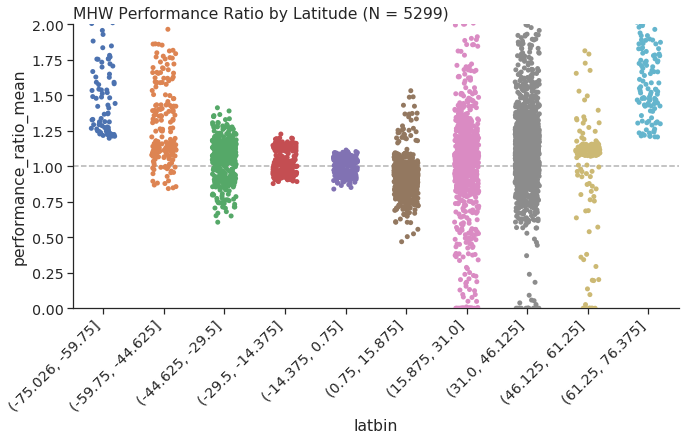

In [362]:
figure = plt.figure(dpi=100)
sns.set(font_scale=1.3, style='ticks')
fg = sns.catplot(kind='strip', x = 'latbin', y = 'performance_ratio_mean', data=a, aspect=2, jitter=0.2)
plt.xticks(rotation=45, ha='right')
plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
plt.title(f"MHW Performance Ratio by Latitude (N = {len(a)})", loc='left')
plt.ylim([-0, 2])


<Figure size 1200x800 with 0 Axes>

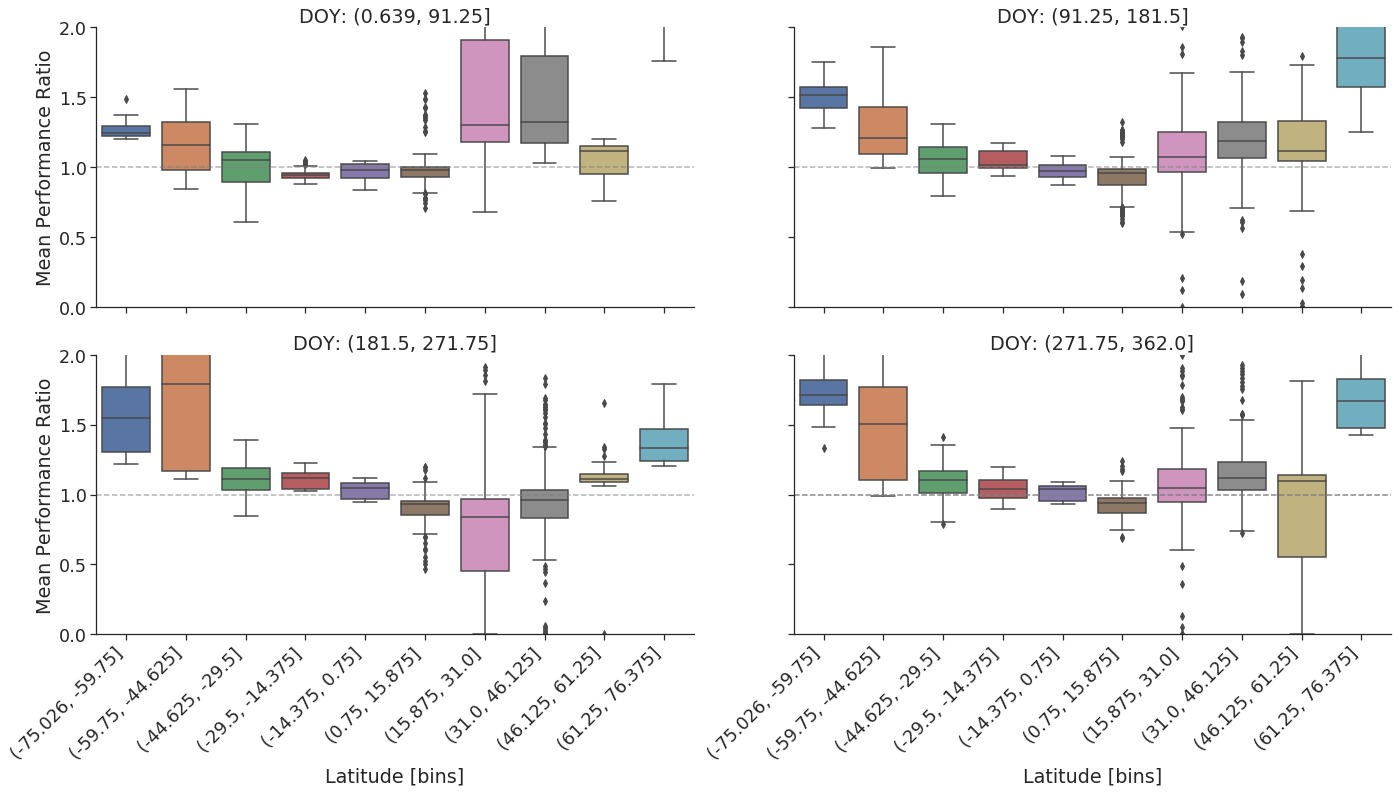

In [417]:
figure = plt.figure(dpi=200)
sns.set(font_scale=1.6, style='ticks')
fg = sns.catplot(kind='box', x = 'latbin', col='doy_bins', col_wrap = 2, y = 'performance_ratio_mean', data=a, aspect=2, )
plt.xticks(rotation=45, ha='right')
plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
# plt.title(f"MHW Performance Ratio by Latitude (N = {len(a)})", loc='left')
list(map(lambda ax: (ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right'), ax.axhline(1,linestyle='--', alpha=0.6, color='gray')), fg.axes));
fg.set(ylim=[0, 2])
fg.set_ylabels('Mean Performance Ratio')
fg.set_xlabels("Latitude [bins]")
fg.set_titles(template='DOY: {col_name}')


Text(0.0, 1, 'MHW Mean Relative Detriment by Latitude (N = 5299)')

<Figure size 600x400 with 0 Axes>

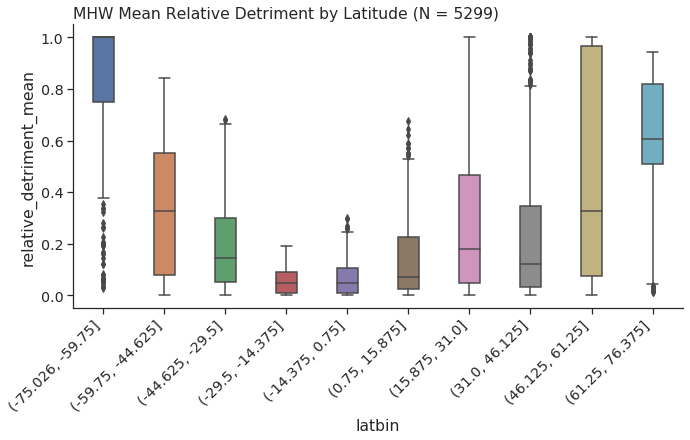

In [356]:
figure = plt.figure(dpi=100)
sns.set(font_scale=1.3, style='ticks')
fg = sns.catplot(kind='box', x = 'latbin', y = 'relative_detriment_mean', data=a, aspect=2, width=0.35)
plt.xticks(rotation=45, ha='right')
# plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
plt.title(f"MHW Mean Relative Detriment by Latitude (N = {len(a)})", loc='left')
# plt.ylim([-1, 2])


## How does this compare to modeled relationships?

Since we have these empirically-derived examples to ground the relationships between environment and performance, it would be nice to take our latitudinally-generalized reaction norm model and apply it to the same environmental record for each of our isolates above and see how the results differ. 

In [462]:
with open("./physiology/gtpc_modeled.pkl", 'rb') as f:
    gtpc = cloudpickle.load(f)

In [466]:
modeled_performances = []
for i, (_, isolate) in tqdm.tqdm(enumerate(plankton.iterrows())):
    
    _tpc = gtpc.getLatitudinalTPC(isolate['isolation.latitude'])
    _relevant_sst = oisst.sel(
        lat=isolate['isolation.latitude'], 
        lon=isolate['isolation.longitude'],
        method='nearest', tolerance=0.25
    )
    _tmin = isolate[tmin_col]
    _tmax = isolate[tmax_col]
    _topt = isolate[topt_col]
    values = xr.apply_ufunc(
        _tpc,
        _relevant_sst.chunk({'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).sst.T
    
    _relevant_mhws = loc_dets_values[i]
    
        
    performance = xr.full_like(_relevant_sst, fill_value=0.).rename_vars({'sst' : "performance"})
    performance['performance_clim'] = xr.zeros_like(performance.performance)
    performance['topt'] = xr.zeros_like(performance.performance)
    performance['tmin'] = xr.zeros_like(performance.performance)
    performance['tmax'] = xr.zeros_like(performance.performance)
    performance.attrs = {}
    
    values_clim = xr.apply_ufunc(
        _tpc,
        _relevant_mhws.clim_seas.chunk({'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).T
    
    performance['performance'] = values
    
    performance['performance_clim'] = values_clim
    
    performance['topt'] = _topt
    
    performance['tmin'] = _tmin
    
    performance['tmax'] = _tmax
    
    modeled_performances.append(performance.assign_coords(isolate = isolate['isolate.code']))
    

89it [00:01, 45.50it/s]


In [468]:
modeled_performance_values = client.compute(modeled_performances, sync=True, optimize_graph=True)

In [472]:
isolate_modeled_performance = [xr.merge(merge) for merge in zip(loc_dets_values, modeled_performance_values)]

In [473]:
modeled_isolates_combined = xr.concat(isolate_modeled_performance, dim='isolate')

In [474]:
modeled_isolates_mhw = modeled_isolates_combined.where((modeled_isolates_combined.mhw != 0))

In [475]:
modeled_isolates_mhws_ddf = modeled_isolates_mhw.to_dask_dataframe().dropna().repartition(npartitions=20)

In [476]:
modeled_isolates_mhws_ddf.performance = modeled_isolates_mhws_ddf.performance.mask(modeled_isolates_mhws_ddf.performance < 0, 0)
modeled_isolates_mhws_ddf.performance_clim = modeled_isolates_mhws_ddf.performance_clim.mask(modeled_isolates_mhws_ddf.performance_clim < 0, 0)

In [483]:
%%time
mhw_events_modeled = modeled_isolates_mhws_ddf.groupby(['lat', 'lon', 'isolate', 'mhw']).apply(compute_mhw_performance).compute()

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


CPU times: user 1.49 s, sys: 120 ms, total: 1.61 s
Wall time: 6.59 s


In [484]:
mhw_events_modeled = mhw_events_modeled.drop('isolate', axis=1).reset_index()

In [485]:
mhw_events_modeled['latbin'] = pd.cut(mhw_events_modeled['lat'], bins=10, )
mhw_events_modeled['doy_bins'] = pd.cut(mhw_events_modeled['start_doy'], bins=4)

Text(0.0, 1, 'MHW Mean Relative Detriment by Latitude (N = 5299)')

<Figure size 600x400 with 0 Axes>

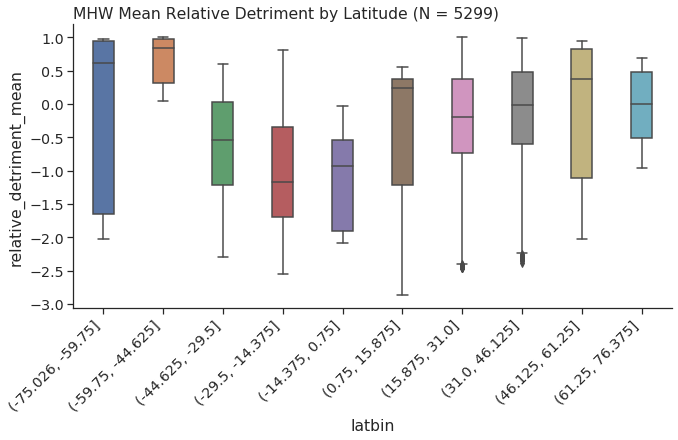

In [486]:
figure = plt.figure(dpi=100)
sns.set(font_scale=1.3, style='ticks')
fg = sns.catplot(kind='box', x = 'latbin', y = 'relative_detriment_mean', data=mhw_events_modeled, aspect=2, width=0.35)
plt.xticks(rotation=45, ha='right')
# plt.axhline(1.0, linestyle='--', alpha=0.6, color='gray')
# plt.ylim([0, 2])
plt.title(f"MHW Mean Relative Detriment by Latitude (N = {len(mhw_events_modeled)})", loc='left')
# plt.ylim([-1, 2])
